# Notebook for DeBERTa-v3-base

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from conllu import TokenList
import polars as pl
from stanza.models.common.doc import Token
from label_legends.preprocess import create_conllu, holdout, load_conllu, load_data, load_train, load_test, transform, load_vectorizer, reverse_vocabulary, vocabulary, ids_to_tokens, tokens_to_ids, vectorize_tokens, strip_stopwords
import logging
import mlflow
from mlflow import MlflowClient
from label_legends.result import calculate_scores, download_predictions, get_experiment, load_predictions, client, get_current
import json

logging.basicConfig(level=logging.INFO)

# Importing dependencies for this specific model

In [25]:
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import time
import numpy as np


In [17]:
from transformers import AutoModelForSequenceClassification, AutoConfig, DebertaV2Tokenizer, Trainer, TrainingArguments
MODEL_NAME = 'microsoft/deberta-v3-base'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer =DebertaV2Tokenizer.from_pretrained(MODEL_NAME)
#DO I need the tokenizer here?

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
load_data().collect()

id,rewire_id,text,annotator,label_sexist,label_category,label_vector,split,tokens
i64,str,str,i64,str,str,str,str,list[str]
0,"""sexism2022_english-0""",""" I wonder what keeps that witc…",17,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
1,"""sexism2022_english-0""",""" I wonder what keeps that witc…",2,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
10,"""sexism2022_english-100""","""Good for her! My grandson had …",3,"""not sexist""","""none""","""none""","""train""","[""good"", ""for"", … ""!""]"
100,"""sexism2022_english-10026""","""It is not insulting, it's **ex…",14,"""sexist""","""2. derogation""","""2.1 descriptive attacks""","""test""","[""it"", ""be"", … "".**""]"
1000,"""sexism2022_english-10297""","""The article said Madonna offer…",5,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""train""","[""the"", ""article"", … "".""]"
…,…,…,…,…,…,…,…,…
9995,"""sexism2022_english-12996""","""Shudder.. if you had to have s…",17,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""test""","[""shudder"", "".."", … "".""]"
9996,"""sexism2022_english-12997""","""You mean one that forces women…",6,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"
9997,"""sexism2022_english-12997""","""You mean one that forces women…",4,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"


### Splitting the dataset to training validation test

In [19]:
val, tra = holdout()
tra = transform(tra)
val = transform(val)

#Not needed as we have done this in the preprocessing
# Convert 'label' column from string '0' and '1' to integer 0 and 1
"""tra = tra.with_columns(
    pl.col("label").cast(pl.Int32)
)
val = val.with_columns(
    pl.col("label").cast(pl.Int32)
)"""

train_texts = tra["text"].to_list()
train_labels = tra["label"].to_list()
val_texts = val["text"].to_list()
val_labels = val["label"].to_list()

test = transform(load_test().collect())
test_texts = test["text"].to_list()
test_labels = test["label"].to_list()


### Tokenizing the splits

In [20]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,  # Adjust this as needed
    return_tensors="pt",
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)
test_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)


In [21]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

    
    
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [32]:
train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)
test_dataset = SexistDataset(test_encodings, test_labels)

In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    evaluation_strategy="epoch",  # Keep this for evaluation at the end of each epoch
    logging_steps=100,  # Log less frequently than every step, but more often than every epoch
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,  # Load best model based on evaluation loss
    metric_for_best_model='eval_loss',  # Track evaluation loss for best model
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/Users/retipeter/Documents/TU Wien/NLP/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/470661135.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Running the model

In [26]:

start_time = time.time()
train_output = trainer.train()  # Returns a TrainOutput object
training_time_manual = time.time() - start_time
train_metrics = train_output.metrics  # Contains train_runtime, train_loss, etc.

# Assume trainer.evaluate() has been run and returned results
eval_results = trainer.evaluate()  # Contains eval_runtime, eval_accuracy, etc.

# Combine training and evaluation metrics
#all_metrics = {**train_metrics, **eval_results}
metrics = {**eval_results}

# Create a Polars DataFrame
df = pl.DataFrame(metrics)
df

  0%|          | 0/11025 [00:00<?, ?it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  1%|          | 100/11025 [00:38<1:07:03,  2.71it/s]

{'loss': 0.5795, 'grad_norm': 1.8887940645217896, 'learning_rate': 1.981859410430839e-05, 'epoch': 0.03}


  2%|▏         | 200/11025 [01:15<1:06:19,  2.72it/s]

{'loss': 0.5461, 'grad_norm': 6.557155132293701, 'learning_rate': 1.963718820861678e-05, 'epoch': 0.05}


  3%|▎         | 300/11025 [01:52<1:05:55,  2.71it/s]

{'loss': 0.5193, 'grad_norm': 14.155360221862793, 'learning_rate': 1.945578231292517e-05, 'epoch': 0.08}


  4%|▎         | 400/11025 [02:29<1:05:12,  2.72it/s]

{'loss': 0.4769, 'grad_norm': 1.0568448305130005, 'learning_rate': 1.9274376417233563e-05, 'epoch': 0.11}


  5%|▍         | 500/11025 [03:06<1:04:32,  2.72it/s]

{'loss': 0.4429, 'grad_norm': 8.496005058288574, 'learning_rate': 1.9092970521541953e-05, 'epoch': 0.14}


  5%|▌         | 600/11025 [03:43<1:04:41,  2.69it/s]

{'loss': 0.4518, 'grad_norm': 8.601648330688477, 'learning_rate': 1.8911564625850343e-05, 'epoch': 0.16}


  6%|▋         | 700/11025 [04:20<1:03:38,  2.70it/s]

{'loss': 0.479, 'grad_norm': 3.98360013961792, 'learning_rate': 1.8730158730158732e-05, 'epoch': 0.19}


  7%|▋         | 800/11025 [04:57<1:02:53,  2.71it/s]

{'loss': 0.4399, 'grad_norm': 4.519546031951904, 'learning_rate': 1.8548752834467122e-05, 'epoch': 0.22}


  8%|▊         | 900/11025 [05:34<1:02:17,  2.71it/s]

{'loss': 0.42, 'grad_norm': 5.970286846160889, 'learning_rate': 1.836734693877551e-05, 'epoch': 0.24}


  9%|▉         | 1000/11025 [06:10<1:01:08,  2.73it/s]

{'loss': 0.4085, 'grad_norm': 3.0715136528015137, 'learning_rate': 1.81859410430839e-05, 'epoch': 0.27}


 10%|▉         | 1100/11025 [06:47<1:00:54,  2.72it/s]

{'loss': 0.4317, 'grad_norm': 3.209310293197632, 'learning_rate': 1.8004535147392294e-05, 'epoch': 0.3}


 11%|█         | 1200/11025 [07:25<1:00:56,  2.69it/s]

{'loss': 0.3944, 'grad_norm': 1.058599829673767, 'learning_rate': 1.782312925170068e-05, 'epoch': 0.33}


 12%|█▏        | 1300/11025 [08:01<59:54,  2.71it/s]  

{'loss': 0.3974, 'grad_norm': 14.883304595947266, 'learning_rate': 1.7641723356009073e-05, 'epoch': 0.35}


 13%|█▎        | 1400/11025 [08:38<58:59,  2.72it/s]  

{'loss': 0.3931, 'grad_norm': 5.255669593811035, 'learning_rate': 1.7460317460317463e-05, 'epoch': 0.38}


 14%|█▎        | 1500/11025 [09:15<58:46,  2.70it/s]  

{'loss': 0.3961, 'grad_norm': 1.8459367752075195, 'learning_rate': 1.7278911564625852e-05, 'epoch': 0.41}


 15%|█▍        | 1600/11025 [09:52<57:52,  2.71it/s]  

{'loss': 0.3971, 'grad_norm': 8.854199409484863, 'learning_rate': 1.7097505668934242e-05, 'epoch': 0.44}


 15%|█▌        | 1700/11025 [10:29<57:17,  2.71it/s]

{'loss': 0.4454, 'grad_norm': 3.956153154373169, 'learning_rate': 1.691609977324263e-05, 'epoch': 0.46}


 16%|█▋        | 1800/11025 [11:06<56:41,  2.71it/s]

{'loss': 0.3927, 'grad_norm': 4.500953197479248, 'learning_rate': 1.673469387755102e-05, 'epoch': 0.49}


 17%|█▋        | 1900/11025 [11:43<56:33,  2.69it/s]

{'loss': 0.3807, 'grad_norm': 2.660168409347534, 'learning_rate': 1.655328798185941e-05, 'epoch': 0.52}


 18%|█▊        | 2000/11025 [12:21<57:32,  2.61it/s]

{'loss': 0.405, 'grad_norm': 6.890281677246094, 'learning_rate': 1.63718820861678e-05, 'epoch': 0.54}


 19%|█▉        | 2100/11025 [12:58<55:02,  2.70it/s]

{'loss': 0.3765, 'grad_norm': 3.054694414138794, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}


 20%|█▉        | 2200/11025 [13:35<54:07,  2.72it/s]

{'loss': 0.37, 'grad_norm': 2.0082945823669434, 'learning_rate': 1.6009070294784583e-05, 'epoch': 0.6}


 21%|██        | 2300/11025 [14:12<53:41,  2.71it/s]

{'loss': 0.4446, 'grad_norm': 8.985652923583984, 'learning_rate': 1.5827664399092972e-05, 'epoch': 0.63}


 22%|██▏       | 2400/11025 [14:49<53:47,  2.67it/s]

{'loss': 0.4011, 'grad_norm': 7.547424793243408, 'learning_rate': 1.5646258503401362e-05, 'epoch': 0.65}


 23%|██▎       | 2500/11025 [15:26<52:36,  2.70it/s]

{'loss': 0.3761, 'grad_norm': 9.5629243850708, 'learning_rate': 1.546485260770975e-05, 'epoch': 0.68}


 24%|██▎       | 2600/11025 [16:03<51:44,  2.71it/s]

{'loss': 0.4129, 'grad_norm': 8.632028579711914, 'learning_rate': 1.528344671201814e-05, 'epoch': 0.71}


 24%|██▍       | 2700/11025 [16:40<51:11,  2.71it/s]

{'loss': 0.3776, 'grad_norm': 4.64011287689209, 'learning_rate': 1.510204081632653e-05, 'epoch': 0.73}


 25%|██▌       | 2800/11025 [17:17<49:26,  2.77it/s]

{'loss': 0.3891, 'grad_norm': 2.892491340637207, 'learning_rate': 1.4920634920634922e-05, 'epoch': 0.76}


 26%|██▋       | 2900/11025 [19:53<49:54,  2.71it/s]   

{'loss': 0.3876, 'grad_norm': 12.65908145904541, 'learning_rate': 1.4739229024943311e-05, 'epoch': 0.79}


 27%|██▋       | 3000/11025 [20:30<49:13,  2.72it/s]

{'loss': 0.3759, 'grad_norm': 4.0728302001953125, 'learning_rate': 1.4557823129251703e-05, 'epoch': 0.82}


 28%|██▊       | 3100/11025 [21:07<48:31,  2.72it/s]

{'loss': 0.3902, 'grad_norm': 1.0634959936141968, 'learning_rate': 1.4376417233560092e-05, 'epoch': 0.84}


 29%|██▉       | 3200/11025 [21:44<48:03,  2.71it/s]

{'loss': 0.3373, 'grad_norm': 4.1765594482421875, 'learning_rate': 1.4195011337868484e-05, 'epoch': 0.87}


 30%|██▉       | 3300/11025 [22:21<47:23,  2.72it/s]

{'loss': 0.3951, 'grad_norm': 1.8797352313995361, 'learning_rate': 1.4013605442176872e-05, 'epoch': 0.9}


 31%|███       | 3400/11025 [22:58<46:50,  2.71it/s]

{'loss': 0.4218, 'grad_norm': 2.5846948623657227, 'learning_rate': 1.3832199546485261e-05, 'epoch': 0.93}


 32%|███▏      | 3500/11025 [23:34<46:29,  2.70it/s]

{'loss': 0.3401, 'grad_norm': 12.419594764709473, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 3600/11025 [24:11<45:30,  2.72it/s]

{'loss': 0.4228, 'grad_norm': 5.562093257904053, 'learning_rate': 1.3469387755102042e-05, 'epoch': 0.98}


                                                    
 33%|███▎      | 3675/11025 [27:00<46:24,  2.64it/s]

{'eval_loss': 0.33505699038505554, 'eval_accuracy': 0.8638888888888889, 'eval_f1': 0.8638888888888889, 'eval_precision': 0.8638888888888889, 'eval_recall': 0.8638888888888889, 'eval_runtime': 140.8363, 'eval_samples_per_second': 89.466, 'eval_steps_per_second': 11.183, 'epoch': 1.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 34%|███▎      | 3700/11025 [27:12<45:59,  2.65it/s]   

{'loss': 0.3964, 'grad_norm': 2.894832134246826, 'learning_rate': 1.3287981859410433e-05, 'epoch': 1.01}


 34%|███▍      | 3800/11025 [27:49<44:26,  2.71it/s]

{'loss': 0.3446, 'grad_norm': 0.6119639873504639, 'learning_rate': 1.3106575963718821e-05, 'epoch': 1.03}


 35%|███▌      | 3900/11025 [28:26<43:41,  2.72it/s]

{'loss': 0.3084, 'grad_norm': 6.781388759613037, 'learning_rate': 1.2925170068027212e-05, 'epoch': 1.06}


 36%|███▋      | 4000/11025 [29:02<43:06,  2.72it/s]

{'loss': 0.342, 'grad_norm': 4.33773946762085, 'learning_rate': 1.2743764172335602e-05, 'epoch': 1.09}


 37%|███▋      | 4100/11025 [29:39<42:35,  2.71it/s]

{'loss': 0.3516, 'grad_norm': 3.1775600910186768, 'learning_rate': 1.2562358276643992e-05, 'epoch': 1.12}


 38%|███▊      | 4200/11025 [30:16<41:54,  2.71it/s]

{'loss': 0.3096, 'grad_norm': 15.63854694366455, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}


 39%|███▉      | 4300/11025 [30:53<40:55,  2.74it/s]

{'loss': 0.3265, 'grad_norm': 10.203651428222656, 'learning_rate': 1.219954648526077e-05, 'epoch': 1.17}


 40%|███▉      | 4400/11025 [31:30<40:17,  2.74it/s]

{'loss': 0.3461, 'grad_norm': 10.260486602783203, 'learning_rate': 1.2018140589569162e-05, 'epoch': 1.2}


 41%|████      | 4500/11025 [32:07<39:57,  2.72it/s]

{'loss': 0.2433, 'grad_norm': 21.30048370361328, 'learning_rate': 1.1836734693877552e-05, 'epoch': 1.22}


 42%|████▏     | 4600/11025 [32:43<39:24,  2.72it/s]

{'loss': 0.3516, 'grad_norm': 13.267343521118164, 'learning_rate': 1.1655328798185943e-05, 'epoch': 1.25}


 43%|████▎     | 4700/11025 [33:20<38:48,  2.72it/s]

{'loss': 0.3381, 'grad_norm': 11.548532485961914, 'learning_rate': 1.1473922902494332e-05, 'epoch': 1.28}


 44%|████▎     | 4800/11025 [33:57<38:16,  2.71it/s]

{'loss': 0.3571, 'grad_norm': 6.922317028045654, 'learning_rate': 1.1292517006802722e-05, 'epoch': 1.31}


 44%|████▍     | 4900/11025 [34:34<37:52,  2.70it/s]

{'loss': 0.3156, 'grad_norm': 9.378880500793457, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}


 45%|████▌     | 5000/11025 [35:11<36:55,  2.72it/s]

{'loss': 0.352, 'grad_norm': 9.70704174041748, 'learning_rate': 1.0929705215419501e-05, 'epoch': 1.36}


 46%|████▋     | 5100/11025 [35:48<36:25,  2.71it/s]

{'loss': 0.3657, 'grad_norm': 18.64288330078125, 'learning_rate': 1.0748299319727893e-05, 'epoch': 1.39}


 47%|████▋     | 5200/11025 [36:24<35:39,  2.72it/s]

{'loss': 0.2966, 'grad_norm': 5.730763912200928, 'learning_rate': 1.0566893424036282e-05, 'epoch': 1.41}


 48%|████▊     | 5300/11025 [37:01<34:52,  2.74it/s]

{'loss': 0.3746, 'grad_norm': 0.7152146697044373, 'learning_rate': 1.0385487528344672e-05, 'epoch': 1.44}


 49%|████▉     | 5400/11025 [37:38<34:27,  2.72it/s]

{'loss': 0.2905, 'grad_norm': 15.649313926696777, 'learning_rate': 1.0204081632653063e-05, 'epoch': 1.47}


 50%|████▉     | 5500/11025 [38:15<33:53,  2.72it/s]

{'loss': 0.3266, 'grad_norm': 11.472578048706055, 'learning_rate': 1.0022675736961451e-05, 'epoch': 1.5}


 51%|█████     | 5600/11025 [38:52<33:21,  2.71it/s]

{'loss': 0.3204, 'grad_norm': 3.415112018585205, 'learning_rate': 9.841269841269842e-06, 'epoch': 1.52}


 52%|█████▏    | 5700/11025 [39:29<32:44,  2.71it/s]

{'loss': 0.3331, 'grad_norm': 7.207555294036865, 'learning_rate': 9.659863945578232e-06, 'epoch': 1.55}


 53%|█████▎    | 5800/11025 [40:06<32:06,  2.71it/s]

{'loss': 0.2925, 'grad_norm': 8.084451675415039, 'learning_rate': 9.478458049886621e-06, 'epoch': 1.58}


 54%|█████▎    | 5900/11025 [40:43<31:27,  2.71it/s]

{'loss': 0.3291, 'grad_norm': 3.1626169681549072, 'learning_rate': 9.297052154195013e-06, 'epoch': 1.61}


 54%|█████▍    | 6000/11025 [41:20<30:52,  2.71it/s]

{'loss': 0.3267, 'grad_norm': 7.34704065322876, 'learning_rate': 9.115646258503402e-06, 'epoch': 1.63}


 55%|█████▌    | 6100/11025 [41:57<30:14,  2.71it/s]

{'loss': 0.3141, 'grad_norm': 2.1960933208465576, 'learning_rate': 8.934240362811792e-06, 'epoch': 1.66}


 56%|█████▌    | 6200/11025 [42:34<29:30,  2.72it/s]

{'loss': 0.3514, 'grad_norm': 9.914813041687012, 'learning_rate': 8.752834467120183e-06, 'epoch': 1.69}


 57%|█████▋    | 6300/11025 [43:10<29:03,  2.71it/s]

{'loss': 0.3217, 'grad_norm': 5.929183006286621, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}


 58%|█████▊    | 6400/11025 [43:47<28:22,  2.72it/s]

{'loss': 0.3243, 'grad_norm': 6.368313312530518, 'learning_rate': 8.390022675736962e-06, 'epoch': 1.74}


 59%|█████▉    | 6500/11025 [44:24<27:49,  2.71it/s]

{'loss': 0.3212, 'grad_norm': 1.0078123807907104, 'learning_rate': 8.208616780045352e-06, 'epoch': 1.77}


 60%|█████▉    | 6600/11025 [45:01<27:12,  2.71it/s]

{'loss': 0.3087, 'grad_norm': 9.536394119262695, 'learning_rate': 8.027210884353741e-06, 'epoch': 1.8}


 61%|██████    | 6700/11025 [45:38<26:32,  2.72it/s]

{'loss': 0.3282, 'grad_norm': 9.00844955444336, 'learning_rate': 7.845804988662133e-06, 'epoch': 1.82}


 62%|██████▏   | 6800/11025 [46:15<25:56,  2.71it/s]

{'loss': 0.3426, 'grad_norm': 9.989607810974121, 'learning_rate': 7.664399092970522e-06, 'epoch': 1.85}


 63%|██████▎   | 6900/11025 [46:52<25:18,  2.72it/s]

{'loss': 0.3061, 'grad_norm': 6.494106292724609, 'learning_rate': 7.482993197278913e-06, 'epoch': 1.88}


 63%|██████▎   | 7000/11025 [47:29<25:09,  2.67it/s]

{'loss': 0.3076, 'grad_norm': 25.49379539489746, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 64%|██████▍   | 7100/11025 [48:06<24:06,  2.71it/s]

{'loss': 0.3223, 'grad_norm': 0.9829422831535339, 'learning_rate': 7.120181405895692e-06, 'epoch': 1.93}


 65%|██████▌   | 7200/11025 [48:43<23:39,  2.69it/s]

{'loss': 0.3473, 'grad_norm': 2.818714141845703, 'learning_rate': 6.938775510204082e-06, 'epoch': 1.96}


 66%|██████▌   | 7300/11025 [49:19<22:52,  2.71it/s]

{'loss': 0.3475, 'grad_norm': 0.6745395660400391, 'learning_rate': 6.757369614512473e-06, 'epoch': 1.99}


                                                    
 67%|██████▋   | 7350/11025 [51:59<22:31,  2.72it/s]

{'eval_loss': 0.3831699788570404, 'eval_accuracy': 0.8707936507936508, 'eval_f1': 0.8707936507936508, 'eval_precision': 0.8707936507936508, 'eval_recall': 0.8707936507936508, 'eval_runtime': 141.207, 'eval_samples_per_second': 89.231, 'eval_steps_per_second': 11.154, 'epoch': 2.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 67%|██████▋   | 7400/11025 [52:20<22:16,  2.71it/s]   

{'loss': 0.318, 'grad_norm': 1.267188310623169, 'learning_rate': 6.575963718820862e-06, 'epoch': 2.01}


 68%|██████▊   | 7500/11025 [52:57<21:37,  2.72it/s]

{'loss': 0.2679, 'grad_norm': 0.1255238950252533, 'learning_rate': 6.394557823129253e-06, 'epoch': 2.04}


 69%|██████▉   | 7600/11025 [53:34<21:01,  2.71it/s]

{'loss': 0.2175, 'grad_norm': 20.092710494995117, 'learning_rate': 6.2131519274376415e-06, 'epoch': 2.07}


 70%|██████▉   | 7700/11025 [54:11<20:21,  2.72it/s]

{'loss': 0.3128, 'grad_norm': 1.8056213855743408, 'learning_rate': 6.031746031746032e-06, 'epoch': 2.1}


 71%|███████   | 7800/11025 [54:47<19:53,  2.70it/s]

{'loss': 0.2633, 'grad_norm': 23.048240661621094, 'learning_rate': 5.850340136054422e-06, 'epoch': 2.12}


 72%|███████▏  | 7900/11025 [55:24<19:06,  2.73it/s]

{'loss': 0.2493, 'grad_norm': 8.886220932006836, 'learning_rate': 5.668934240362812e-06, 'epoch': 2.15}


 73%|███████▎  | 8000/11025 [56:01<18:35,  2.71it/s]

{'loss': 0.3054, 'grad_norm': 36.90859603881836, 'learning_rate': 5.487528344671202e-06, 'epoch': 2.18}


 73%|███████▎  | 8100/11025 [56:38<17:55,  2.72it/s]

{'loss': 0.3053, 'grad_norm': 30.384233474731445, 'learning_rate': 5.306122448979593e-06, 'epoch': 2.2}


 74%|███████▍  | 8200/11025 [57:15<17:28,  2.70it/s]

{'loss': 0.2761, 'grad_norm': 7.6898722648620605, 'learning_rate': 5.124716553287983e-06, 'epoch': 2.23}


 75%|███████▌  | 8300/11025 [57:51<16:46,  2.71it/s]

{'loss': 0.3344, 'grad_norm': 7.2226948738098145, 'learning_rate': 4.943310657596373e-06, 'epoch': 2.26}


 76%|███████▌  | 8400/11025 [58:28<16:04,  2.72it/s]

{'loss': 0.2688, 'grad_norm': 0.5166671872138977, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}


 77%|███████▋  | 8500/11025 [59:05<15:32,  2.71it/s]

{'loss': 0.2833, 'grad_norm': 3.897116184234619, 'learning_rate': 4.580498866213152e-06, 'epoch': 2.31}


 78%|███████▊  | 8600/11025 [59:42<14:53,  2.71it/s]

{'loss': 0.315, 'grad_norm': 0.2103673666715622, 'learning_rate': 4.399092970521542e-06, 'epoch': 2.34}


 79%|███████▉  | 8700/11025 [1:00:19<14:09,  2.74it/s]

{'loss': 0.297, 'grad_norm': 0.28199225664138794, 'learning_rate': 4.217687074829933e-06, 'epoch': 2.37}


 80%|███████▉  | 8800/11025 [1:00:56<13:37,  2.72it/s]

{'loss': 0.3006, 'grad_norm': 7.998861789703369, 'learning_rate': 4.036281179138322e-06, 'epoch': 2.39}


 81%|████████  | 8900/11025 [1:01:32<12:56,  2.74it/s]

{'loss': 0.2392, 'grad_norm': 7.915376663208008, 'learning_rate': 3.854875283446712e-06, 'epoch': 2.42}


 82%|████████▏ | 9000/11025 [1:02:09<12:20,  2.73it/s]

{'loss': 0.2935, 'grad_norm': 5.504988193511963, 'learning_rate': 3.6734693877551024e-06, 'epoch': 2.45}


 83%|████████▎ | 9100/11025 [1:02:46<11:49,  2.72it/s]

{'loss': 0.2709, 'grad_norm': 5.341680526733398, 'learning_rate': 3.492063492063492e-06, 'epoch': 2.48}


 83%|████████▎ | 9200/11025 [1:03:23<11:15,  2.70it/s]

{'loss': 0.3668, 'grad_norm': 1.675034761428833, 'learning_rate': 3.3106575963718824e-06, 'epoch': 2.5}


 84%|████████▍ | 9300/11025 [1:04:00<10:54,  2.63it/s]

{'loss': 0.2595, 'grad_norm': 0.9223145842552185, 'learning_rate': 3.1292517006802725e-06, 'epoch': 2.53}


 85%|████████▌ | 9400/11025 [1:04:37<09:58,  2.72it/s]

{'loss': 0.2862, 'grad_norm': 11.55428695678711, 'learning_rate': 2.947845804988662e-06, 'epoch': 2.56}


 86%|████████▌ | 9500/11025 [1:05:14<09:20,  2.72it/s]

{'loss': 0.2851, 'grad_norm': 1.1552919149398804, 'learning_rate': 2.7664399092970525e-06, 'epoch': 2.59}


 87%|████████▋ | 9600/11025 [1:05:51<08:43,  2.72it/s]

{'loss': 0.2958, 'grad_norm': 0.23802973330020905, 'learning_rate': 2.5850340136054425e-06, 'epoch': 2.61}


 88%|████████▊ | 9700/11025 [1:06:28<08:08,  2.71it/s]

{'loss': 0.3279, 'grad_norm': 0.46002396941185, 'learning_rate': 2.4036281179138325e-06, 'epoch': 2.64}


 89%|████████▉ | 9800/11025 [1:07:04<07:28,  2.73it/s]

{'loss': 0.2679, 'grad_norm': 12.855155944824219, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}


 90%|████████▉ | 9900/11025 [1:07:41<06:54,  2.71it/s]

{'loss': 0.2765, 'grad_norm': 0.8737837672233582, 'learning_rate': 2.0408163265306125e-06, 'epoch': 2.69}


 91%|█████████ | 10000/11025 [1:08:18<06:16,  2.72it/s]

{'loss': 0.2892, 'grad_norm': 13.643295288085938, 'learning_rate': 1.8594104308390023e-06, 'epoch': 2.72}


 92%|█████████▏| 10100/11025 [1:08:55<05:39,  2.72it/s]

{'loss': 0.2497, 'grad_norm': 11.434124946594238, 'learning_rate': 1.6780045351473925e-06, 'epoch': 2.75}


 93%|█████████▎| 10200/11025 [1:09:32<05:04,  2.71it/s]

{'loss': 0.3092, 'grad_norm': 10.119606018066406, 'learning_rate': 1.4965986394557825e-06, 'epoch': 2.78}


 93%|█████████▎| 10300/11025 [1:10:09<04:28,  2.71it/s]

{'loss': 0.2799, 'grad_norm': 0.7776430249214172, 'learning_rate': 1.3151927437641723e-06, 'epoch': 2.8}


 94%|█████████▍| 10400/11025 [1:10:46<03:49,  2.72it/s]

{'loss': 0.295, 'grad_norm': 12.056020736694336, 'learning_rate': 1.1337868480725626e-06, 'epoch': 2.83}


 95%|█████████▌| 10500/11025 [1:11:23<03:13,  2.71it/s]

{'loss': 0.2992, 'grad_norm': 10.564102172851562, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


 96%|█████████▌| 10600/11025 [1:12:00<02:37,  2.70it/s]

{'loss': 0.2303, 'grad_norm': 9.34415340423584, 'learning_rate': 7.709750566893425e-07, 'epoch': 2.88}


 97%|█████████▋| 10700/11025 [1:12:37<01:59,  2.71it/s]

{'loss': 0.3218, 'grad_norm': 15.329351425170898, 'learning_rate': 5.895691609977325e-07, 'epoch': 2.91}


 98%|█████████▊| 10800/11025 [1:13:14<01:23,  2.69it/s]

{'loss': 0.2828, 'grad_norm': 0.8955135941505432, 'learning_rate': 4.0816326530612243e-07, 'epoch': 2.94}


 99%|█████████▉| 10900/11025 [1:13:51<00:46,  2.71it/s]

{'loss': 0.337, 'grad_norm': 0.8660726547241211, 'learning_rate': 2.267573696145125e-07, 'epoch': 2.97}


100%|█████████▉| 11000/11025 [1:18:33<00:09,  2.77it/s]  

{'loss': 0.286, 'grad_norm': 0.5793271660804749, 'learning_rate': 4.53514739229025e-08, 'epoch': 2.99}


100%|██████████| 11025/11025 [1:18:42<00:00,  2.77it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                                                       
100%|██████████| 11025/11025 [1:21:29<00:00,  2.77it/s]

{'eval_loss': 0.4618639051914215, 'eval_accuracy': 0.8684126984126984, 'eval_f1': 0.8684126984126984, 'eval_precision': 0.8684126984126984, 'eval_recall': 0.8684126984126984, 'eval_runtime': 164.3397, 'eval_samples_per_second': 76.67, 'eval_steps_per_second': 9.584, 'epoch': 3.0}


100%|██████████| 11025/11025 [1:21:32<00:00,  2.77it/s]

{'train_runtime': 4892.2685, 'train_samples_per_second': 18.028, 'train_steps_per_second': 2.254, 'train_loss': 0.34411954386704635, 'epoch': 3.0}


100%|██████████| 11025/11025 [1:21:33<00:00,  2.25it/s]
/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1575/1575 [02:20<00:00, 11.19it/s]


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.335057,0.863889,0.863889,0.863889,0.863889,140.9585,89.388,11.174,3.0


## Validation set predict

In [27]:
predicted = trainer.predict(val_dataset)

y_pred_val = np.argmax(predicted.predictions, axis=1) 
y_true_val = predicted.label_ids 

/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1575/1575 [02:21<00:00, 11.15it/s]


In [36]:
predicted

PredictionOutput(predictions=array([[ 1.4283584 , -1.9602209 ],
       [ 1.3240527 , -1.7595761 ],
       [ 1.290572  , -1.6995648 ],
       ...,
       [ 0.9903713 , -1.2800969 ],
       [ 0.68039113, -0.98649246],
       [-1.2874719 ,  1.4352661 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.33505699038505554, 'test_accuracy': 0.8638888888888889, 'test_f1': 0.8638888888888889, 'test_precision': 0.8638888888888889, 'test_recall': 0.8638888888888889, 'test_runtime': 141.3022, 'test_samples_per_second': 89.171, 'test_steps_per_second': 11.146})

## Test set predict

In [30]:
predicted_test = trainer.predict(test_dataset)

y_pred = np.argmax(predicted_test.predictions, axis=1)
y_true = predicted_test.label_ids



/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_72852/2940528382.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1500/1500 [02:14<00:00, 11.15it/s]


In [56]:
predicted_test

PredictionOutput(predictions=array([[ 1.4283584, -1.9602209],
       [ 1.3240527, -1.7595761],
       [ 1.290572 , -1.6995648],
       ...,
       [ 1.2412537, -1.6844519],
       [ 1.6854733, -2.0212564],
       [ 1.648259 , -2.017082 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.9730005860328674, 'test_accuracy': 0.6263333333333333, 'test_f1': 0.6263333333333333, 'test_precision': 0.6263333333333333, 'test_recall': 0.6263333333333333, 'test_runtime': 134.7814, 'test_samples_per_second': 89.033, 'test_steps_per_second': 11.129})

## I got the logits of the model which need to be converted with sigmoid to get the probabilities of each class

In [55]:
#Kind of uneccessary but I thought I needed it for the final output.
#Didn't know how it worked so I investigated and found out that predicted_test.predictions are logits which need to be converted to get the probs of each class
placeholder = torch.tensor(predicted_test.predictions)
classes_predicted = torch.sigmoid(placeholder)
classes_predicted

tensor([[0.8066, 0.1234],
        [0.7899, 0.1468],
        [0.7842, 0.1545],
        ...,
        [0.7758, 0.1565],
        [0.8436, 0.1170],
        [0.8387, 0.1174]])

In [57]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

## Confusion Matrix

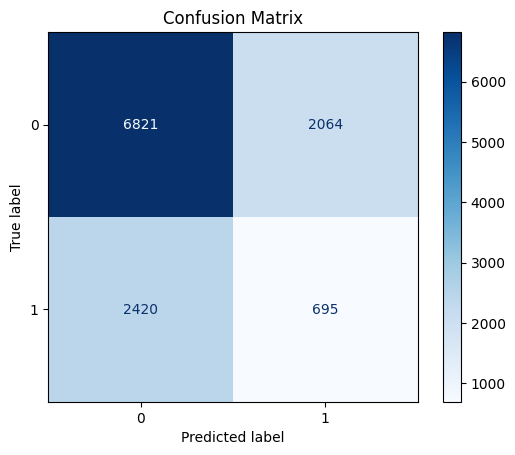

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

# New team standardized evaluation of the model

In [34]:
scores = calculate_scores(y_true, y_pred)
print(scores)

precision:	0.2519
recall:		0.2231
fscore:		0.2366
accuracy:	0.6263
tn: 6821	 fp: 2064
fn: 2420	 tp: 695


In [59]:
mlflow.end_run()

In [60]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="DeBERTa-v3-base testing"
        ):
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("max_length", 128)
    mlflow.log_param("learning_rate", 5e-5)

    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "DeBERTa-v3")

    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions_DeBERTa.json")

    #log the model
    prediction_data = {
        "columns": ["id", "prediction"],
        "data": [[id_, pred.tolist()] for id_, pred in zip(test["id"], y_pred)]
    }
    # Save to a JSON file
    predictions_file = r"../resource/mlflow/DeBERTa/predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(prediction_data, f, indent=4)
        
    # Log the JSON file as an artifact
    mlflow.log_artifact(predictions_file)
        
    # Simulate model registration
    mlflow.set_tag("registered_model_name", "DeBERTa-v3")
    mlflow.set_tag("model_alias", "current")

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/predictions_DeBERTa.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="DeBERTa-v3") 


client().set_registered_model_alias("DeBERTa-v3", "current", registered_model.version)

Registered model 'DeBERTa-v3' already exists. Creating a new version of this model...
Created version '6' of model 'DeBERTa-v3'.


In [49]:
get_current("DeBERTa-v3")

<ModelVersion: aliases=['current'], creation_timestamp=1734095133214, current_stage='None', description=None, last_updated_timestamp=1734095133214, name='DeBERTa-v3', run_id='415a7611941840b7b305e5c52a8217a5', run_link=None, source='file:///Users/retipeter/Documents/TU%20Wien/NLP/nlp-ie-label-legends/notebooks/mlruns/943899761474513424/415a7611941840b7b305e5c52a8217a5/artifacts/predictions_DeBERTa.json', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [51]:
load_predictions("DeBERTa").head()

id,prediction
i64,list[f64]
100,"[1.428358, -1.960221]"
10005,"[1.324053, -1.759576]"
10006,"[1.290572, -1.699565]"
10007,"[0.92231, -1.229401]"
10008,"[1.659326, -2.049543]"
